In [1]:
using PyPlot, StatsBase, Printf, DelimitedFiles;
using Revise;
using MDToolbox;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/nakayama/.julia/packages/Revise/AMRie/src/Revise.jl:1167
┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/nakayama/.julia/packages/CUDAdrv/aBgcd/src/CUDAdrv.jl:69


### Potential energy function

In [2]:
V(x; k=1.0) = sum(- (1.0 / 2.0) .* k .* x.^2 .+ (1.0 ./ 4.0) .* k .* x.^4)
V([0.0], k=1.0)

0.0

### Proposal distribution

In [3]:
proposal_fun(x) = x .+ (rand(Float64, size(x)) .* 2.0 .- 1.0);
proposal_fun([0.0])

1-element Array{Float64,1}:
 -0.9042917773541008

### Replica MCMC without exchange

In [4]:
nreplica = 4
temperature_replica = [0.01, 0.10, 0.30, 0.40];
nstep = 1000;
nexchange = 20;

x_replica = []
for i = 1:nreplica
    x = [0.0]
    push!(x_replica, x)
end

io_replica = []
for i = 1:nreplica
    filename = "replica$(i).dat"
    io = open(filename, "w")
    push!(io_replica, io)
end

for iexchange = 1:nexchange
    for i = 1:nreplica
        x_replica[i] = propagate_mcmc(y -> V(y, k=1.0), proposal_fun, x_replica[i], temperature_replica[i], nstep=nstep, io=io_replica[i]);
    end
    # do not exchange
end

for i = 1:nreplica
    close(io_replica[i])
end

### Trajectory analysis

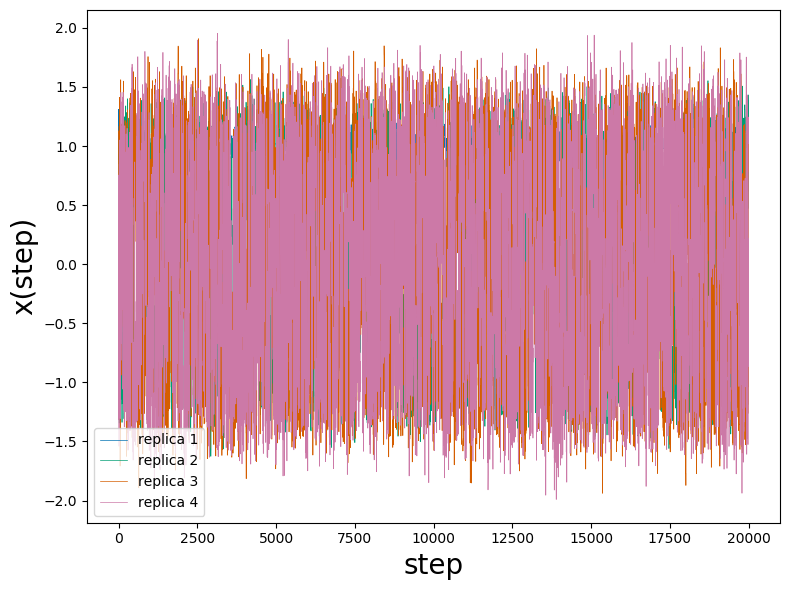

In [5]:
traj_replica = []
temp_replica = []

for i = 1:nreplica
    filename = "replica$(i).dat"
    data = readdlm(filename);
    push!(temp_replica, data[:, 1])
    push!(traj_replica, data[:, 2])
end

fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_replica[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["replica 1", "replica 2", "replica 3", "replica 4"])
tight_layout()

In [31]:
x_grid = range(-1.3, 1.3, length=100);
pmf_theory = V.(x_grid, k=1) ./ temperature_replica[1]
pmf_theory .= pmf_theory .- minimum(pmf_theory);

In [32]:
pmf_observed, _ = getpmf(traj_replica[1], grid_x = collect(x_grid), bandwidth=0.05);

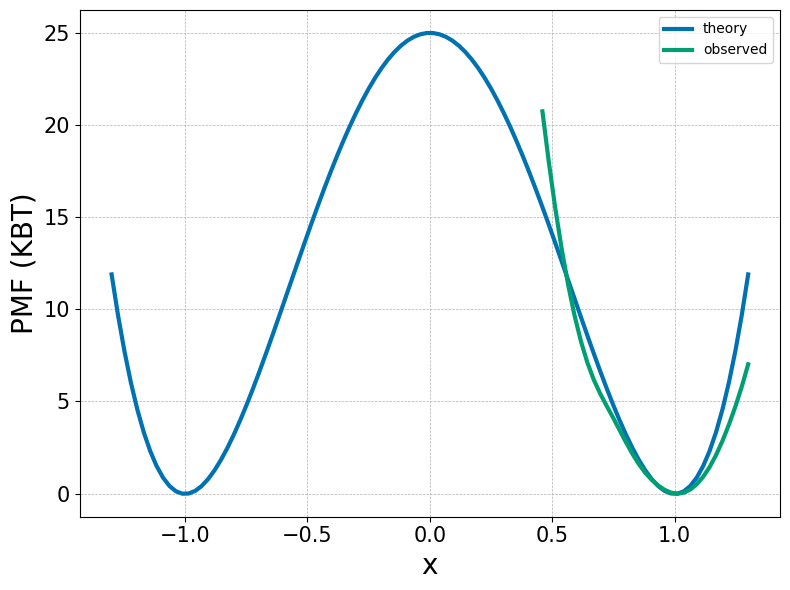

In [35]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(x_grid, pmf_theory, linewidth=3)
xlabel("x",fontsize=20)
ylabel("PMF (KBT)",fontsize=20)

ax.plot(x_grid, pmf_observed, linewidth=3)

ax.legend(["theory", "observed"])

ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()
savefig("mcmc_replica_noexchange.png", dpi=350)